# Cargamos los datos

In [1]:
import cv2
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# 1. Función para cargar imágenes y máscaras
def load_images_and_masks(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
    
    images, masks, ids = [], [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and mask is not None:
            images.append(img)
            masks.append(mask)
            ids.append(os.path.splitext(img_file)[0])
    return images, masks, ids

# Evaluamos pixeles de carretera y no carretera

In [2]:
# Función para obtener píxeles blancos (carretera)
def get_white_pixels(mask, size):
    pixels_selected_white = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea blanco y no esté ya seleccionado
        if mask[x, y] >= 128 and [x, y] not in pixels_selected_white:
            pixels_selected_white.append([x, y])
            i += 1
    return pixels_selected_white

# Función para obtener píxeles negros (no carretera)
def get_black_pixels(mask, size):
    pixels_selected_black = []
    i = 0
    while i < size:
        x = random.randint(0, mask.shape[0] - 1)
        y = random.randint(0, mask.shape[1] - 1)
        # Verificar que el píxel sea negro y no esté ya seleccionado
        if mask[x, y] < 128 and [x, y] not in pixels_selected_black:
            pixels_selected_black.append([x, y])
            i += 1
    return pixels_selected_black


# Creamos las ventanas

In [3]:

# 2. Función para extraer ventanas con padding
def extract_window(image, center, window_size):
    half = window_size // 2
    padded_window = np.zeros((window_size, window_size, 3), dtype=np.uint8)
    x, y = center
    for i in range(-half, half):
        for j in range(-half, half):
            img_x, img_y = x + i, y + j
            if 0 <= img_x < image.shape[0] and 0 <= img_y < image.shape[1]:
                padded_window[i + half, j + half] = image[img_x, img_y]
    return padded_window

# 3. Guardar ventanas en directorios organizados
def save_windows(X, Y, img_id, output_dir, window_size):
    img_dir = os.path.join(output_dir, img_id)
    carretera_dir = os.path.join(img_dir, "Carretera")
    no_carretera_dir = os.path.join(img_dir, "No_Carretera")
    os.makedirs(carretera_dir, exist_ok=True)
    os.makedirs(no_carretera_dir, exist_ok=True)
    
    for idx, (window, label) in enumerate(zip(X, Y)):
        filename = f"win_{idx}_{label}.png"
        path = os.path.join(carretera_dir if label == 1 else no_carretera_dir, filename)
        reshaped_window = window.reshape((window_size, window_size, 3))
        cv2.imwrite(path, reshaped_window)
    print(f"Ventanas guardadas en {img_dir}")

# **RGB: Baseline**

In [4]:
def generate_training_data(images, masks, ids, window_size, num_samples, output_dir):
    for img, mask, img_id in zip(images, masks, ids):
        X_train, Y_train = [], []  # Reiniciar para cada imagen
        # Obtener píxeles blancos y negros
        white_pixels = get_white_pixels(mask, num_samples)
        black_pixels = get_black_pixels(mask, num_samples)
        # Extraer ventanas y etiquetas
        for pixel in white_pixels + black_pixels:
            window = extract_window(img, pixel, window_size).flatten()
            label = 1 if mask[pixel[0], pixel[1]] >= 128 else 0
            X_train.append(window)
            Y_train.append(label)
        # Guardar ventanas solo de la imagen actual
        save_windows(X_train, Y_train, img_id, output_dir, window_size)
    print("Datos de entrenamiento generados correctamente.")

    return np.array(X_train), np.array(Y_train)  # Asegurarse de devolver los datos de entrenamiento


# Evaluar imagenes completas

In [5]:
# 7. Evaluar imágenes completas
def evaluate_on_image(model, image, mask, window_size):
    rows, cols = image.shape[:2]
    predictions = np.zeros((rows, cols), dtype=np.uint8)
    Y_true, Y_pred = [], []
    for i in range(rows):
        for j in range(cols):
            window = extract_window(image, (i, j), window_size).flatten()
            pred = model.predict([window])[0]
            predictions[i, j] = pred
            Y_true.append(1 if mask[i, j] >= 128 else 0)
            Y_pred.append(pred)
    print(classification_report(Y_true, Y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_true, Y_pred))
    return predictions

# Modelos

In [6]:
# Entrenamiento del modelo Random Forest
def train_rf_model(X_train, Y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, Y_train)
    print("Modelo entrenado correctamente.")
    return model

In [7]:
from sklearn.svm import SVC  # Importar Support Vector Classifier

def train_svm_model(X_train, Y_train):
    # Inicializar el clasificador SVM con un kernel lineal o 'rbf' (radial basis function)
    model = SVC(kernel='rbf', random_state=42)  # 'linear' o 'poly' tmb vale
    # Ajustar el modelo a los datos de entrenamiento
    model.fit(X_train, Y_train)
    print("Modelo SVM entrenado correctamente.")
    return model

# Utilizaremos la metrica IoU

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from collections import defaultdict
from sklearn.model_selection import KFold



# Metricas
def calculate_metrics(Y_true, Y_pred):
    metrics = {}
    tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()

    metrics['IoU'] =  tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    metrics['Precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['Recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['F1-Score'] = 2 * metrics['Precision'] * metrics['Recall'] / \
                          (metrics['Precision'] + metrics['Recall']) if (metrics['Precision'] + metrics['Recall']) > 0 else 0
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['Balanced Accuracy'] = (metrics['Recall'] + metrics['Specificity']) / 2
    return metrics

# K-Fold Cross Validation
def kfold_cross_validation(X, Y, model_function, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold_idx + 1}/{n_splits}")
        
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Entrenar el modelo
        model = model_function(X_train, Y_train)

        # Predicciones
        Y_pred = model.predict(X_test)

        # Calcular métricas
        metrics = calculate_metrics(Y_test, Y_pred)
        fold_metrics.append(metrics)

        # Mostrar métricas del fold
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Calcular promedio, desviación estándar y rango
    overall_metrics = defaultdict(dict)
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        overall_metrics[metric]['mean'] = np.mean(values)
        overall_metrics[metric]['std'] = np.std(values)
        overall_metrics[metric]['range'] = (np.min(values), np.max(values))

    # Reportar métricas finales
    print("\nMétricas promedio, desviación estándar y rango:")
    for metric, stats in overall_metrics.items():
        print(f"{metric}: {stats['mean']:.4f} ± {stats['std']:.4f} (rango: {stats['range'][0]:.4f} - {stats['range'][1]:.4f})")
    
    return overall_metrics

In [9]:
# 8. Visualizar resultados
def visualize_predictions(image, mask, predictions):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(predictions, cmap='gray')
    plt.axis("off")
    plt.show()

# Ejecución del pipeline completo

In [10]:
image_dir = "Dataset1_roads/sat"
mask_dir = "Dataset1_roads/gt"
output_dir = "Dataset1_roads/windows"

# Cargar datos
images, masks, ids = load_images_and_masks(image_dir, mask_dir)

In [ ]:
# Generar datos de entrenamiento
X_train, Y_train = generate_training_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=100, output_dir=output_dir)

# Entrenar modelo
model = train_rf_model(X_train, Y_train)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16)

mean_iou = kfold_cross_validation(X_train, Y_train, train_rf_model, n_splits=5)

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

Ventanas guardadas en Dataset1_roads/windows\10078675_15
Ventanas guardadas en Dataset1_roads/windows\10228675_15
Ventanas guardadas en Dataset1_roads/windows\10228705_15
Ventanas guardadas en Dataset1_roads/windows\10228720_15
Ventanas guardadas en Dataset1_roads/windows\10228735_15
Ventanas guardadas en Dataset1_roads/windows\10228750_15
Ventanas guardadas en Dataset1_roads/windows\10378675_15
Ventanas guardadas en Dataset1_roads/windows\10378690_15
Ventanas guardadas en Dataset1_roads/windows\10378705_15
Ventanas guardadas en Dataset1_roads/windows\10378720_15
Ventanas guardadas en Dataset1_roads/windows\10378735_15
Ventanas guardadas en Dataset1_roads/windows\10378750_15
Ventanas guardadas en Dataset1_roads/windows\10378765_15
Ventanas guardadas en Dataset1_roads/windows\10528675_15
Ventanas guardadas en Dataset1_roads/windows\10528690_15
Ventanas guardadas en Dataset1_roads/windows\10528705_15
Ventanas guardadas en Dataset1_roads/windows\10528720_15
Ventanas guardadas en Dataset1_

Ventanas guardadas en Dataset1_roads/windows\10078675_15
Ventanas guardadas en Dataset1_roads/windows\10228675_15
Ventanas guardadas en Dataset1_roads/windows\10228705_15
Ventanas guardadas en Dataset1_roads/windows\10228720_15
Ventanas guardadas en Dataset1_roads/windows\10228735_15
Ventanas guardadas en Dataset1_roads/windows\10228750_15
Ventanas guardadas en Dataset1_roads/windows\10378675_15
Ventanas guardadas en Dataset1_roads/windows\10378690_15
Ventanas guardadas en Dataset1_roads/windows\10378705_15
Ventanas guardadas en Dataset1_roads/windows\10378720_15
Ventanas guardadas en Dataset1_roads/windows\10378735_15
Ventanas guardadas en Dataset1_roads/windows\10378750_15
Ventanas guardadas en Dataset1_roads/windows\10378765_15
Ventanas guardadas en Dataset1_roads/windows\10528675_15
Ventanas guardadas en Dataset1_roads/windows\10528690_15
Ventanas guardadas en Dataset1_roads/windows\10528705_15
Ventanas guardadas en Dataset1_roads/windows\10528720_15
Ventanas guardadas en Dataset1_

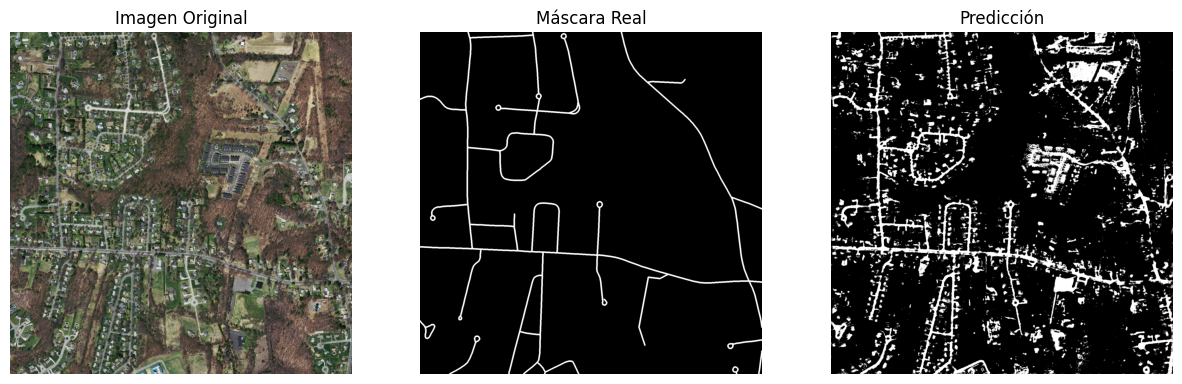

In [ ]:
# Generar datos de entrenamiento
X_train, Y_train = generate_training_data(images[:-1], masks[:-1], ids[:-1], window_size=16, num_samples=2000, output_dir=output_dir)

# Entrenar modelo
model = train_rf_model(X_train, Y_train)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16)

mean_iou = kfold_cross_validation(X_train, Y_train, train_rf_model, n_splits=5)

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

In [ ]:
# Entrenar modelo
model = train_svm_model(X_train, Y_train)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16)

mean_iou = kfold_cross_validation(X_train, Y_train, train_svm_model, n_splits=5)

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

NameError: name 'X_train' is not defined

# AÑADIMOS CARACTERISTICAS

In [ ]:
def calculate_orientation_tensor(window):
    """
    Calcula las características basadas en el tensor de orientación para una ventana de imagen.
    """
    # Convertir a escala de grises para gradientes
    gray_window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
    
    # Derivadas en x e y (gradientes)
    grad_x = cv2.Sobel(gray_window, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_window, cv2.CV_64F, 0, 1, ksize=3)
    
    # Componentes del tensor
    Ixx = grad_x**2
    Ixy = grad_x * grad_y
    Iyy = grad_y**2
    
    # Promediar los componentes (puedes aplicar un filtro gaussiano si es necesario)
    Txx = np.mean(Ixx)
    Txy = np.mean(Ixy)
    Tyy = np.mean(Iyy)
    
    # Calcular los eigenvalores (λ1, λ2) para caracterizar orientación
    trace = Txx + Tyy
    det = Txx * Tyy - Txy**2
    lambda1 = (trace + np.sqrt(trace**2 - 4 * det)) / 2
    lambda2 = (trace - np.sqrt(trace**2 - 4 * det)) / 2

    # Coherencia como medida adicional
    coherency = (lambda1 - lambda2) / (lambda1 + lambda2 + 1e-5)  # Evitar división por cero

    # Devuelve un vector que combina eigenvalores y coherencia
    return np.array([lambda1, lambda2, coherency])

In [ ]:
import numpy as np
from skimage.feature import hog
from skimage import color


def extract_feature(window, feature_type):
    """
    Extrae diferentes características de una ventana de la imagen dependiendo del tipo especificado.
    Permite combinar HOG con orientación basada en tensores.
    """
    if feature_type == 'brightness':
        # Brillo (promedio ponderado de los valores RGB)
        return np.mean(0.299 * window[:, :, 0] + 0.587 * window[:, :, 1] + 0.114 * window[:, :, 2])

    elif feature_type == 'contrast':
        # Contraste (varianza dentro de la ventana)
        return np.var(window)

    elif feature_type == 'hog':
        # HOG (Histograma de Gradientes Orientados)
        features, _ = hog(window, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                          visualize=True, multichannel=True)
        return features
    
    elif feature_type == 'tensor':
        # Solo orientación basada en tensores
        return calculate_orientation_tensor(window)

    elif feature_type == 'entropy':
        # Convertir la imagen a escala de grises
        grayscale_window = np.mean(window, axis=2).astype(np.uint8)
        # Calcular el histograma
        hist, _ = np.histogram(grayscale_window, bins=256, range=(0, 256), density=True)
        # Eliminar ceros para evitar problemas con log2
        hist = hist[hist > 0]
        # Calcular la entropía
        entropy = -np.sum(hist * np.log2(hist))
        return entropy

    else:
        raise ValueError(f"Feature type {feature_type} not recognized.")


def generate_training_data_with_features(X_train, Y_train, window_size, feature_types):
    """
    Genera datos de entrenamiento con una o más características.
    """
    all_features = []

    for window in X_train:
        # Asegurarse de que la ventana tenga dimensiones esperadas
        window_reshaped = window.reshape(window_size, window_size, 3)
        combined_features = []

        # Calcular características según los tipos especificados
        for feature_type in feature_types:
            feature = extract_feature(window_reshaped, feature_type)
            if isinstance(feature, np.ndarray):
                combined_features.extend(feature)  # Si es un array (HOG, Tensor, etc.), extiende la lista
            else:
                combined_features.append(feature)  # Si es un valor escalar (brillo, contraste, etc.), añade directamente

        # Aplanar la ventana original y concatenar con las características calculadas
        features = np.concatenate([window.flatten(), combined_features])
        all_features.append(features)

    return np.array(all_features), np.array(Y_train)

In [ ]:
def evaluate_on_image(model, image, mask, window_size, feature_type):
    rows, cols = image.shape[:2]
    predictions = np.zeros((rows, cols), dtype=np.uint8)
    Y_true, Y_pred = [], []
    for i in range(rows):
        for j in range(cols):
            window = extract_window(image, (i, j), window_size).flatten()
            feature = extract_feature(image[i:i+window_size, j:j+window_size], feature_type)
            features = np.append(window, feature)  # Concatenar la característica extraída
            pred = model.predict([features])[0]
            predictions[i, j] = pred
            Y_true.append(1 if mask[i, j] >= 128 else 0)
            Y_pred.append(pred)
    
    print(classification_report(Y_true, Y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(Y_true, Y_pred))
    
    return predictions

# BRILLO

In [ ]:
# Generar datos de entrenamiento
X_train_ft, Y_train = generate_training_data_with_features(X_train, Y_train, window_size=16, feature_types='brightness')

# Entrenar modelo
model = train_svm_model(X_train_ft, Y_train)

kfold_cross_validation(X_train_ft, Y_train, train_svm_model, n_splits=5)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16, feature_types='brightness')

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

In [ ]:
# Generar datos de entrenamiento
X_train_ft, Y_train = generate_training_data_with_features(X_train, Y_train, window_size=16, feature_types='brightness')

# Entrenar modelo
model = train_rf_model(X_train_ft, Y_train)

kfold_cross_validation(X_train_ft, Y_train, train_rf_model, n_splits=5)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16, feature_types='brightness')

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

# CONTRASTE

In [ ]:
# Generar datos de entrenamiento
X_train_ft, Y_train = generate_training_data_with_features(X_train, Y_train, window_size=16, feature_type='contrast')

# Entrenar modelo
model = train_svm_model(X_train_ft, Y_train)

kfold_cross_validation(X_train_ft, Y_train, train_svm_model, n_splits=5)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16, feature_type='contrast')

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

# HOG Y TENSOR

In [ ]:
# Generar datos de entrenamiento
X_train_ft, Y_train = generate_training_data_with_features(X_train, Y_train, window_size=16, feature_types=['hog', 'tensor'])

# Entrenar modelo
model = train_svm_model(X_train_ft, Y_train)

kfold_cross_validation(X_train_ft, Y_train, train_svm_model, n_splits=5)

# Evaluar modelo en una imagen completa
predictions = evaluate_on_image(model, images[-1], masks[-1], window_size=16, feature_types='hog')

# Visualizar resultados
visualize_predictions(images[-1], masks[-1], predictions)

In [ ]:
def calculate_gradients(window):
    gray_window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
    grad_x = np.mean(cv2.Sobel(gray_window, cv2.CV_64F, 1, 0, ksize=3))
    grad_y = np.mean(cv2.Sobel(gray_window, cv2.CV_64F, 0, 1, ksize=3))
    return grad_x, grad_y
